In [1]:
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet
from pybrain.structure import FullConnection, FeedForwardNetwork, TanhLayer, LinearLayer, BiasUnit, SigmoidLayer, GaussianLayer, SoftmaxLayer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import r2_score
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv("RealEstate.csv", index_col=[0])
df.head()

,value,livingSpace
id,,
0,1750000,500
1,357660,153
2,699000,245
3,332950,148
4,352950,173


## Look at the Data

(0, 900.0)

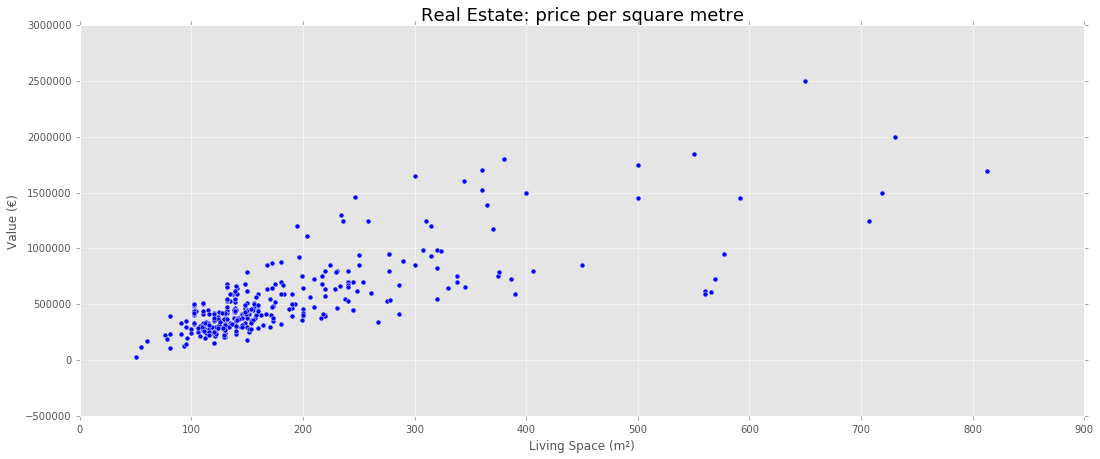

In [3]:
plt.figure(figsize=(18,7))

plt.scatter( df.livingSpace, df.value, s = 25,)

plt.ylabel(u"Value (€)")
plt.xlabel(u"Living Space (m²)")
plt.title("Real Estate: price per square metre", fontsize = 18)
plt.xlim(0,)

# Create a Neural Network

In [4]:
#Initialize the NN
fnn = FeedForwardNetwork()

#Input Layer with 1 Neuron because there is one X var
inLayer = LinearLayer(1, name ="Linear Inpute")
#One Hidden Layer: with Sigmoid Activation function and 4 Neurons
hiddenLayer = SigmoidLayer(4, name ="Sig Hidden")
#Output Layer: Linear because it's a regression.
#One Neuron, because there is one output value
outLayer = LinearLayer(1, name="Linear Out")


#Declare them as Modules of the NeuralNetwork
fnn.addInputModule(inLayer)
fnn.addModule(hiddenLayer)
fnn.addOutputModule(outLayer)

#Connect each layer
from pybrain.structure import FullConnection
in_to_hidden = FullConnection(inLayer, hiddenLayer)
hidden_to_out = FullConnection(hiddenLayer, outLayer)

fnn.addConnection(in_to_hidden)
fnn.addConnection(hidden_to_out)

#Finalize the Neural Network
fnn.sortModules()

#### Turn the Data into a SupervisedDataSet

In [5]:
y = df.value
x = df.livingSpace

#Normalize the Data with L2 Normalization
#PyBrain NN do not properly work with large values

wy = np.sqrt(sum(y**2))
wx = np.sqrt(sum(x**2))
y_norm = y/wy
x_norm = x/wx

In [6]:
#1,1 because one input and one output value
DS = SupervisedDataSet( 1, 1 )

#Append Linked: x,y
for i in range(len(df)):
    DS.appendLinked((x_norm.ix[i]),(y_norm.ix[i]))

#### Build and use the Trainer

In [24]:
#Learning Rate shouldnt be bigger than 0.01
t = BackpropTrainer(fnn, learningrate = 0.001, momentum = 0.99, verbose = False,lrdecay=0.9999)

#Training on the DataSet with 1000 epochs
t.trainOnDataset(DS, 1000)

# Model Evaluation

In [25]:
y_pred = fnn.activateOnDataset(DS)
#"DeNormalize" Again to turn the data into the original monetary value
y_pred = y_pred * wy

In [26]:
#Create the DataSet for a RegressionLine

x_pred = np.arange(5,870, 10)



DS_Eval = SupervisedDataSet( 1, 0 )
#Append Linked: x,y
for i in range(len(x_pred)):
    #Divide the X value by the L2 X-Weight
    DS_Eval.appendLinked((x_pred[i]/wx),())
nn_regressionLine = fnn.activateOnDataset(DS_Eval)
#Always multiply with the L2 normalization weight
nn_regressionLine = nn_regressionLine*wy

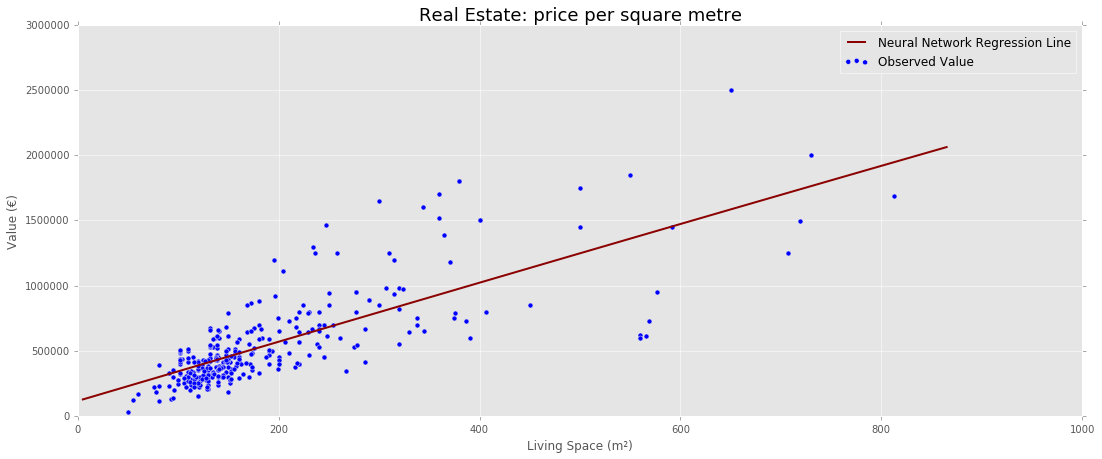

In [27]:
plt.figure(figsize=(18,7))

plt.scatter( df.livingSpace, df.value, s = 25,)

plt.plot(x_pred, nn_regressionLine, color = "darkred", lw = 2)

plt.ylabel(u"Value (€)")
plt.xlabel(u"Living Space (m²)")
plt.title("Real Estate: price per square metre", fontsize = 18)
plt.xlim(0,)
plt.ylim(0,)

plt.legend([ "Neural Network Regression Line","Observed Value"])

## R2 Evaluation Score

In [28]:
r2_score = sklearn.metrics.r2_score(y, y_pred)
r2_score

0.59337239146243848

### Comparison with OLS Linear Regression

In [29]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [30]:
linearRegression = OLS(y,sm.add_constant(x)).fit()
linReg_r2_score = linearRegression.rsquared

In [31]:
print "Neural Network R2:", round(r2_score,4)
print "Linear Regression R2:", round(linReg_r2_score,4)

Neural Network R2: 0.5934
Linear Regression R2: 0.5937
